# Introduction

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today), Zillow has since become established as one of the largest, most trusted marketplaces for real estate information in the U.S. and a leading example of impactful machine learning.

In this million-dollar competition, participants will develop an algorithm that makes predictions about the future sale prices of homes. The contest is structured into two rounds, the qualifying round which opens May 24, 2017 and the private round for the 100 top qualifying teams that opens on Feb 1st, 2018. In the qualifying round, you’ll be building a model to improve the Zestimate residual error. In the final round, you’ll build a home valuation algorithm from the ground up, using external data sources to help engineer new features that give your model an edge over the competition.

The dataset consists of information about 2.9 million properties and has the following 2 files:
* properties_2016.csv (contains property related information)
* train_2016.csv (contains transaction information)

In [131]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse, stats
import datetime as dt
import time

from sklearn import preprocessing, metrics, pipeline
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Load Data

In [197]:
train = pd.read_csv('/Users/Grace/Desktop/DS175/Zillow Prize/train_2016_v2.csv')
properties = pd.read_csv('/Users/Grace/Desktop/DS175/Zillow Prize/properties_2016.csv')
dictionary = pd.read_excel('/Users/Grace/Desktop/DS175/Zillow Prize/zillow_data_dictionary.xlsx')

In [194]:
print train.shape
print properties.shape

(90275, 3)
(2985217, 58)


In [221]:
#train['logerror_abs'] = train.logerror.abs()
train['transactiondate'] = pd.to_datetime(train['transactiondate'])
train['transaction_mo'] = train['transactiondate'].apply(lambda x: x.month).astype(str)
properties['tax_amount_over_value'] = properties['taxamount'] / properties['taxvaluedollarcnt']

In [222]:
train_df = pd.merge(train, properties, how='left', on='parcelid')
print train_df.shape

(90275, 62)


# Exploratory Data Analysis

## Univariate EDA

### Logerror

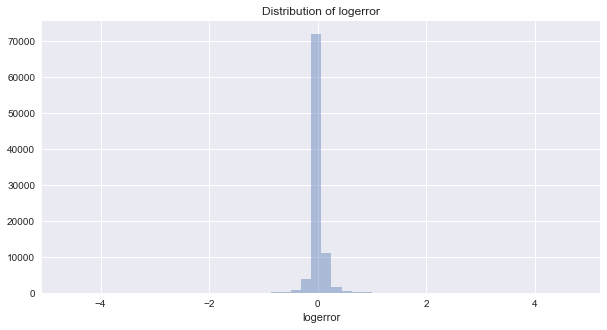

In [51]:
plt.figure(figsize=(10,5))
sns.distplot(train_df.logerror, bins=50, kde=False)
plt.xlabel('logerror')
plt.title('Distribution of logerror', fontsize = 12)

There seems to be outliers. So I will plot the central 98% of logerror.

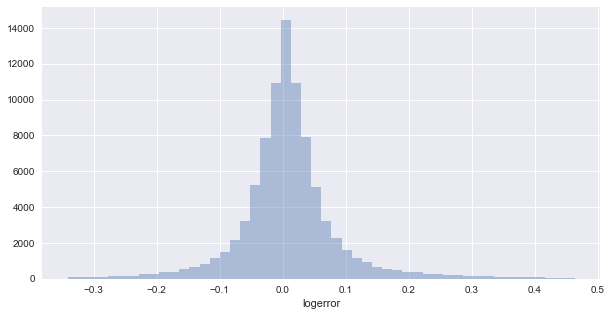

In [68]:
upper = np.percentile(train_df.logerror.values, 99)
lower = np.percentile(train_df.logerror.values, 1)
plt.figure(figsize=(10,5))
sns.distplot(train_df.query('logerror<%f and logerror>%f' % (upper, lower)).logerror.values, bins = 50, kde = False)
plt.xlabel('logerror')

This distribution after removing 1% upper and lower bounds is perfectly normal distributed.

### Lot Size
Lot size might be important based on intuition.

In [11]:
train_df.lotsizesquarefeet.describe()

count    8.012500e+04
mean     2.911016e+04
std      1.217213e+05
min      1.670000e+02
25%      5.703000e+03
50%      7.200000e+03
75%      1.168600e+04
max      6.971010e+06
Name: lotsizesquarefeet, dtype: float64

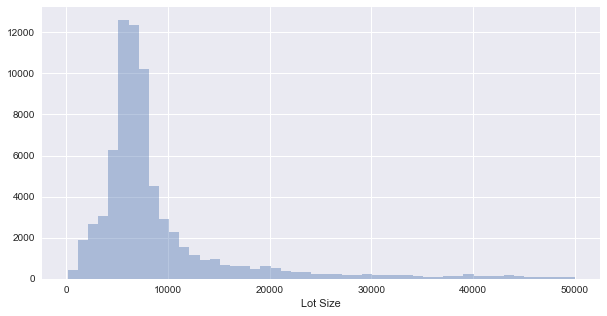

In [22]:
plt.figure(figsize = (10,5))
#sns.distplot(train_df.lotsizesquarefeet.dropna(), bins=50, kde = False)
sns.distplot(train_df.query('lotsizesquarefeet>0 & lotsizesquarefeet<50000').lotsizesquarefeet.values, bins=50, kde = False)
plt.xlabel('Lot Size') 

Lot size seems to slightly left-skewed with a long tail.

### Built Year 

In [26]:
train_df.yearbuilt.describe()

count    89519.000000
mean      1968.532870
std         23.763475
min       1885.000000
25%       1953.000000
50%       1970.000000
75%       1987.000000
max       2015.000000
Name: yearbuilt, dtype: float64

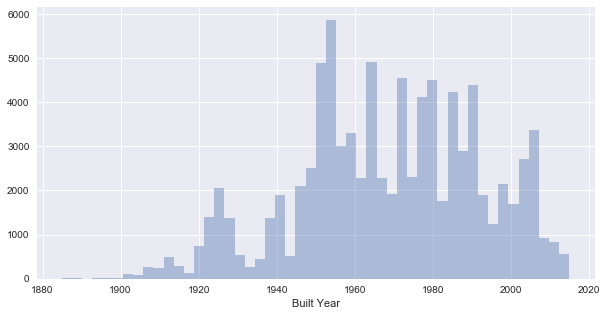

In [38]:
plt.figure(figsize = (10,5))
sns.distplot(train_df.yearbuilt.dropna(), bins= 50, kde = False)
plt.xlabel('Built Year')

More properties were built around 1950s, followed by the 1960-1990 range.

### Tax Assessed Value - taxvaluedollarcnt

taxvaluedollarcnt is the total tax assessed value. It is commonly used to estimate the 'relative value' of a property, which might be important for logerror.

In [51]:
train_df.taxvaluedollarcnt.describe()

count    9.027400e+04
mean     4.576726e+05
std      5.548844e+05
min      2.200000e+01
25%      1.990232e+05
50%      3.428720e+05
75%      5.405890e+05
max      2.775000e+07
Name: taxvaluedollarcnt, dtype: float64

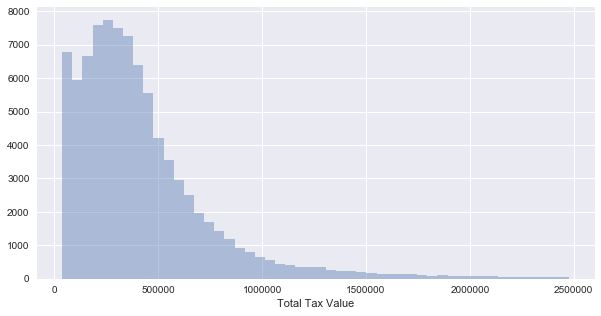

In [60]:
upper = np.percentile(train_df.taxvaluedollarcnt.dropna(), 99)
lower = np.percentile(train_df.taxvaluedollarcnt.dropna(), 1)
plt.figure(figsize=(10,5))
sns.distplot(train_df.query('taxvaluedollarcnt>%f & taxvaluedollarcnt<%f' % (lower, upper)).taxvaluedollarcnt, bins=50, kde = False)
plt.xlabel('Total Tax Value')

After removing some outlier, tax amount is left-skewed.

### Tax Amount

taxamount is the total property tax assessed for that assest.

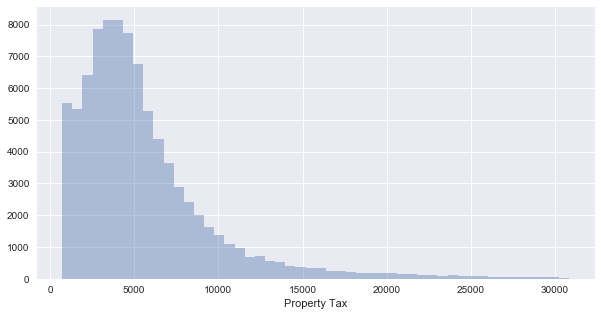

In [61]:
upper = np.percentile(train_df.taxamount.dropna(), 99)
lower = np.percentile(train_df.taxamount.dropna(), 1)
plt.figure(figsize=(10,5))
sns.distplot(train_df.query('taxamount>%f & taxamount<%f' % (lower, upper)).taxamount, bins=50, kde = False)
plt.xlabel('Property Tax')

### Transaction Month

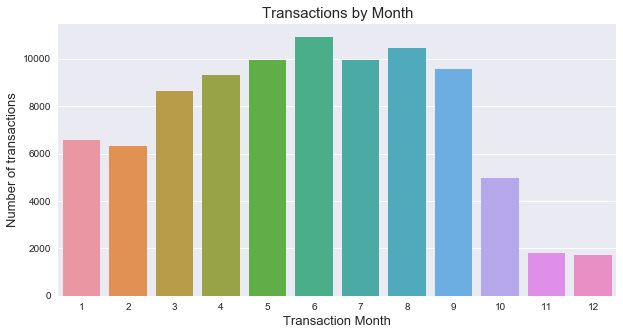

In [265]:
cnt = train_df['transaction_mo'].astype(int).value_counts()
plt.figure(figsize=(10,5))
sns.barplot(cnt.index, cnt.values)
plt.ylabel('Number of transactions', fontsize=13)
plt.xlabel('Transaction Month', fontsize=13)
plt.title('Transactions by Month', fontsize=15)

* Please note that the train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.
* It seems that Jan, Feb have the lower transaction amount compared with other month. 

### Living Area

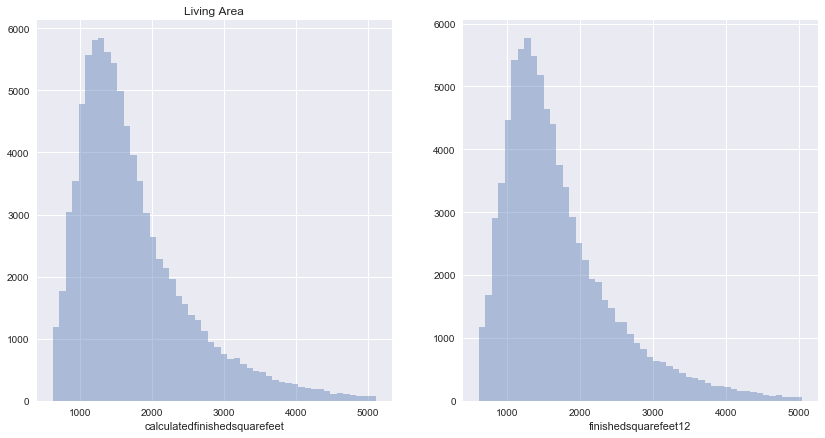

In [259]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
upper = np.percentile(train_df.calculatedfinishedsquarefeet.dropna(), 99)
lower = np.percentile(train_df.calculatedfinishedsquarefeet.dropna(), 1)
sns.distplot(train_df.query('calculatedfinishedsquarefeet>%f & calculatedfinishedsquarefeet<%f' % (lower, upper)).calculatedfinishedsquarefeet, bins=50, kde=False)
plt.title('Living Area')
plt.subplot(1,2,2)
upper = np.percentile(train_df.finishedsquarefeet12.dropna(), 99)
lower = np.percentile(train_df.finishedsquarefeet12.dropna(), 1)
sns.distplot(train_df.query('finishedsquarefeet12>%f & finishedsquarefeet12<%f' % (lower, upper)).finishedsquarefeet12, bins=50, kde = False)

### Bedroom

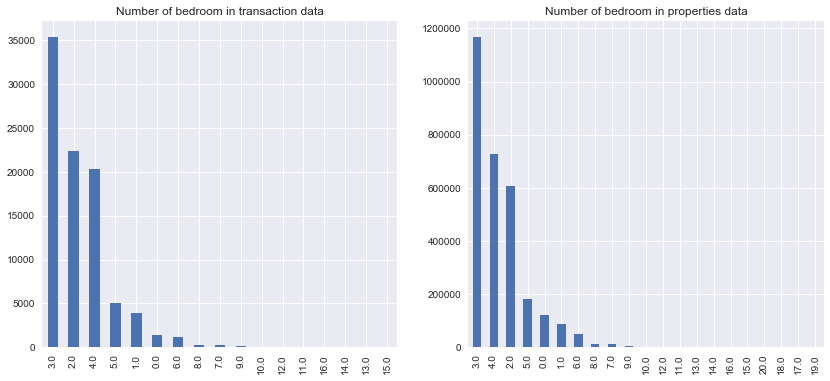

In [277]:
plt.figure(figsize=(14,6))
plt.subplot(121)
train_df['bedroomcnt'].value_counts().plot.bar()
plt.title('Number of bedroom in transaction data')
plt.subplot(122)
properties['bedroomcnt'].value_counts().plot.bar()
plt.title('Number of bedroom in properties data')

3-bedroom is the most popular one, followed by 2B and 4B in the both datasets. 

## Multivariate EDA

### log error vs tax value

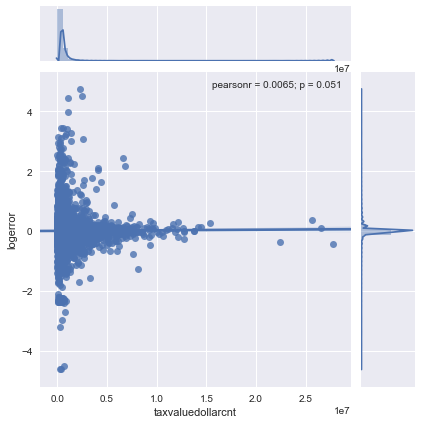

In [86]:
sns.jointplot('taxvaluedollarcnt', 'logerror', train_df, kind='reg')

This doesn't give much information.

In [236]:
train_df['logerror_abs'] = train_df.logerror.abs()

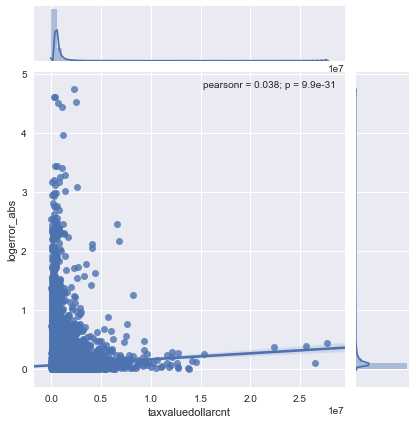

In [87]:
sns.jointplot('taxvaluedollarcnt', 'logerror_abs', train_df, kind='reg')

Now we can see a clear pattern that Zestimate's predictive power decreases as price increases. Predictions on high-end properties might be an opportunity in Zestimate.

### tax amount vs tax assessed value

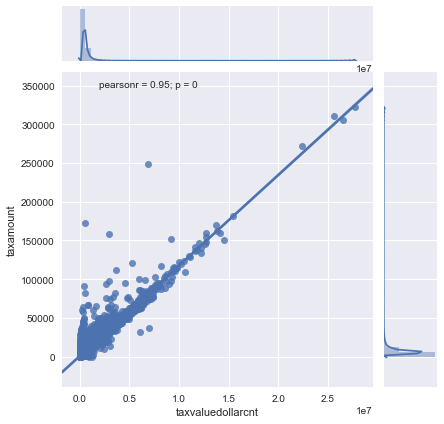

In [240]:
sns.jointplot('taxvaluedollarcnt', 'taxamount', train_df, kind='reg')

The outliers may indicate 1) different tax rate policies 2) conservative tax assessment.

### lot size vs tax value

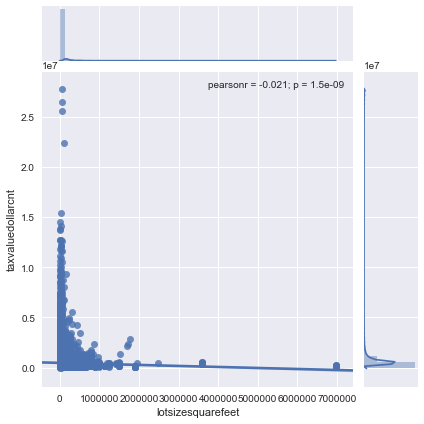

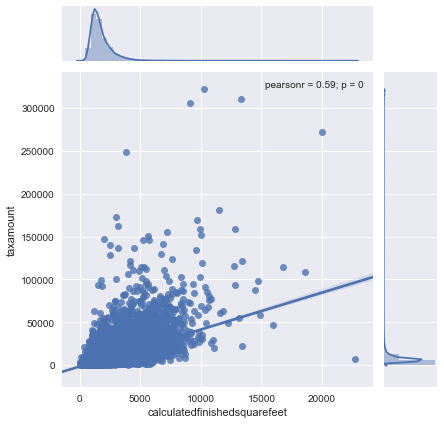

In [263]:
sns.jointplot('lotsizesquarefeet', 'taxvaluedollarcnt', train_df, kind='reg')
sns.jointplot('calculatedfinishedsquarefeet', 'taxamount', train_df, kind='reg')

Lot size and tax amount seem to be correlated.

### Architecture style vs logerror

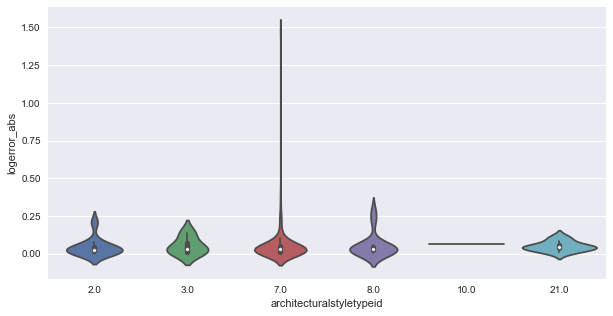

In [99]:
plt.figure(figsize=(10,5))
sns.violinplot(x='architecturalstyletypeid', y='logerror_abs', data=train_df)

There are outliers in architecture style 7. Now let's take a closer look at these styles with boxplot.

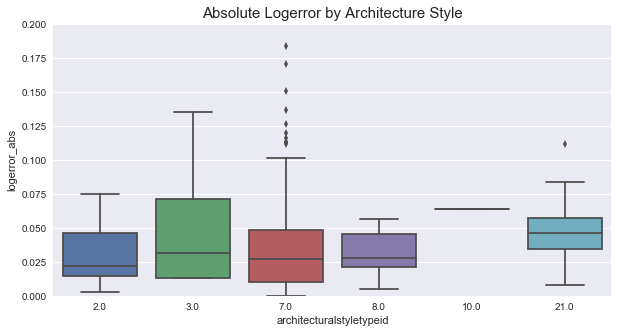

In [122]:
plt.figure(figsize=(10,5))
axes = plt.gca()
axes.set_ylim([0,0.2])
sns.boxplot(x='architecturalstyletypeid', y='logerror_abs', data=train_df)
plt.title('Absolute Logerror by Architecture Style', fontsize=15)

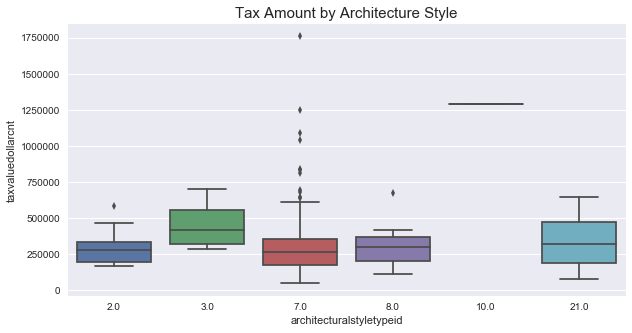

In [37]:
plt.figure(figsize=(10,5))
sns.boxplot(x='architecturalstyletypeid', y='taxvaluedollarcnt', data=train_df)
plt.title('Tax Amount by Architecture Style', fontsize=15)

Interestingly, even though style 7 has some outliers in logerror, it is the least expensive style, on average.

## Missing Values

In [162]:
missing_df = (train_df.isnull().sum()/train_df.shape[0]).reset_index()
missing_df.columns = ['variable', 'missing_count']
missing_df = missing_df[missing_df['missing_count'] > 0]
missing_df = missing_df.sort_values(by='missing_count')

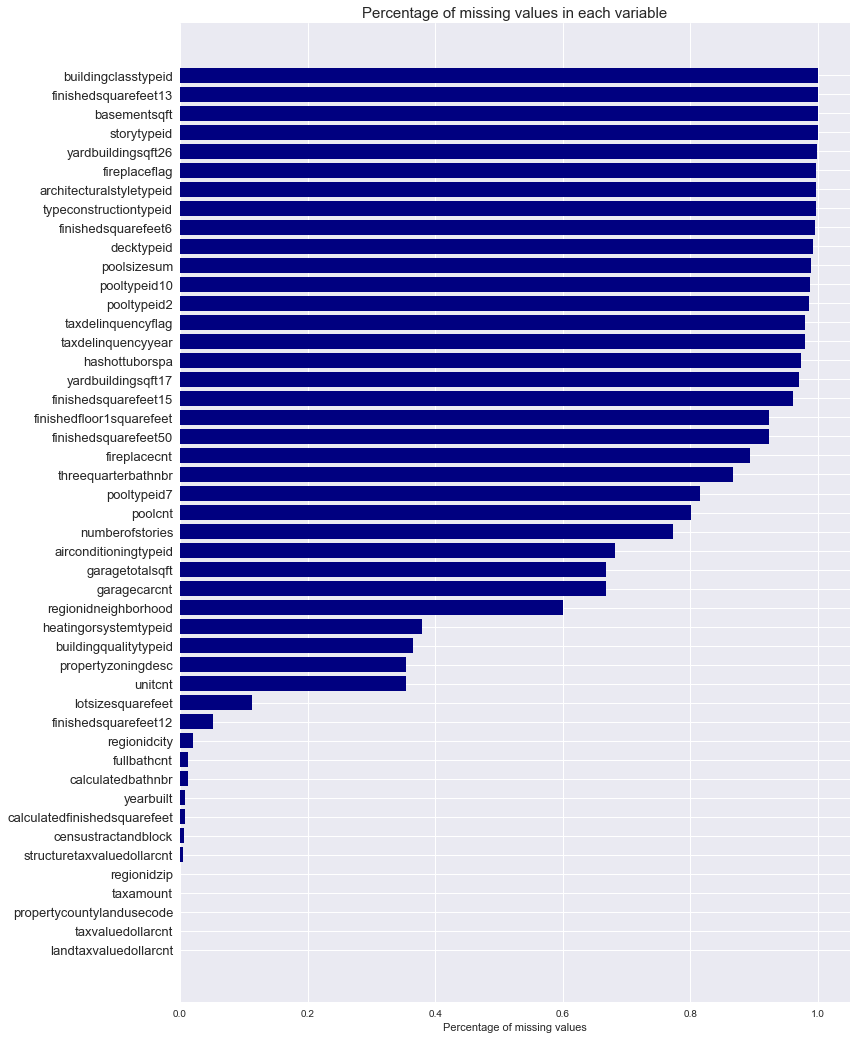

In [288]:
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='navy')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.variable.values, rotation='horizontal', fontsize=13)
ax.set_xlabel("Percentage of missing values")
ax.set_title("Percentage of missing values in each variable", fontsize=15)
plt.show()

# Data Preprocessing

### Create New Features

In [142]:
# change transactiondate to date format
train_df['tax_amount_over_value'] = train_df['taxamount'] / train_df['taxvaluedollarcnt']
properties['tax_amount_over_value'] = properties['taxamount'] / properties['taxvaluedollarcnt']

### Group Variables

We will segment features into groups since they will be preprocessed in different ways.

In [110]:
data_types = train_df.dtypes
cat_vars = list(data_types[data_types=='object'].index)
num_vars = list(data_types[data_types=='int64'].index) + list(data_types[data_types=='float64'].index)
dt_vars = list(data_types[data_types=='datetime64[ns]'].index) 

id_var = 'id'
target_var = 'logerror'
num_vars.remove('parcelid')
num_vars.remove('logerror')
num_vars.remove('logerror_abs')

print '*There are %d categorical features, %d numerical and %d datetime ones' % (len(cat_vars), len(num_vars), len(dt_vars))
print '*Categorical features: ', cat_vars
print '*Numerical features: ', num_vars
print '*Datetime features: ', dt_vars
print '*ID: %s, target: %s' % (id_var, target_var)

*There are 6 categorical features, 53 numerical and 1 datetime ones
*Categorical features:  ['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag', 'transaction_mo']
*Numerical features:  ['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid', 'threequarterbathnbr', 'typecon

## Categorical Features: Label Encoding

* Only works for tree-based models
* Prerequisite for One-Hot-Encoding
* Easier and faster to implement
* Needs less memory and time to finish

In [145]:
LBL = preprocessing.LabelEncoder()

LE_vars = []
LE_map = {}
start = time.time()
for cat_var in cat_vars:
    print "Label Encoding %s" % (cat_var)
    LE_var = cat_var+'_le'
    train_df[LE_var] = LBL.fit_transform(train_df[cat_var].astype(str).fillna('none'))
    LE_vars.append(LE_var)
    LE_map[cat_var] = LBL.classes_
print 'Label-encoding finished in %f seconds' % (time.time()-start)    
print "Label-encoded features: %s" % LE_vars

Label Encoding hashottuborspa
Label Encoding propertycountylandusecode
Label Encoding propertyzoningdesc
Label Encoding fireplaceflag
Label Encoding taxdelinquencyflag
Label Encoding transaction_mo
Label-encoding finished in 0.680598 seconds
Label-encoded features: ['hashottuborspa_le', 'propertycountylandusecode_le', 'propertyzoningdesc_le', 'fireplaceflag_le', 'taxdelinquencyflag_le', 'transaction_mo_le']


In [146]:
# create label encoding in properties:
cat_vars2 = cat_vars[:5]
for cat_var in cat_vars2:
    print "Label Encoding %s" % (cat_var)
    LE_var = cat_var+'_le'
    properties[LE_var] = LBL.fit_transform(properties[cat_var].astype(str).fillna('none'))

Label Encoding hashottuborspa
Label Encoding propertycountylandusecode
Label Encoding propertyzoningdesc
Label Encoding fireplaceflag
Label Encoding taxdelinquencyflag


## Categorical Features: One Hot Encoding

* Works for both linear and tree-based model
* Exclusive to Label-Encoding, i.e. it's not recommended to include both Label-encoded and One-hot-encoded features to the model. However, they could supplement each other by ensemble.

In [73]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start = time.time()
OHE.fit(train_df[LE_vars])
OHE_sparse = OHE.transform(train_df[LE_vars])
print 'One-hot-encoding finished in %f seconds' % (time.time()-start)

OHE_vars = [var[:-3] + '_' + str(level).replace(' ', '-') 
            for var in cat_vars for level in LE_map[var]] 
print "OHE_sparse size : ", OHE_sparse.shape
print "One-hot encoded categorical feature samples: %s" % (OHE_vars[:20]) 

One-hot-encoding finished in 0.277223 seconds
OHE_sparse size :  (90275, 2093)
One-hot encoded categorical feature samples: ['hashottubor_True', 'hashottubor_nan', 'propertycountylandusec_0', 'propertycountylandusec_010', 'propertycountylandusec_0100', 'propertycountylandusec_0101', 'propertycountylandusec_0102', 'propertycountylandusec_0103', 'propertycountylandusec_0104', 'propertycountylandusec_0108', 'propertycountylandusec_0109', 'propertycountylandusec_010C', 'propertycountylandusec_010D', 'propertycountylandusec_010E', 'propertycountylandusec_010F', 'propertycountylandusec_010G', 'propertycountylandusec_010H', 'propertycountylandusec_010M', 'propertycountylandusec_010V', 'propertycountylandusec_0110']


# Modelling

### XGBoost

We will leverage XGBoost as the baseline models for the following reasons:
* XGBoost is robust to missing values and outliers
* XGBoost needs minimum tuning to work well and runs fast
* XGBoost provides feature importance

### Cross Validation

We will use XGBoost's CV function to get the optimal value for one of the most important XGBoost parameters: num_of_round (n_estimators).
###### Let's start with minimum features: numerical features + label_encoded categorical features.

In [155]:
#LE_vars.remove('transaction_mo_le')
cv_vars = num_vars + LE_vars
train_x=train_df[cv_vars]
train_y=train_df['logerror'].values.astype(np.float64)
test_x = properties[cv_vars]

#xgboost params
xgb_params = {
    'eta': 0.05,
    'max_depth': 4,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'silent': 1,
    'seed': 1234
}

dtrain = xgb.DMatrix(train_x, train_y)
dtest = xgb.DMatrix(test_x)

# cross-validation
cv_result = xgb.cv(xgb_params,
                  dtrain,
                  nfold=5,
                  num_boost_round=10000,
                  early_stopping_rounds=50,
                  verbose_eval=10,
                  show_stdv=False,
                  seed = 1234)

[0]	train-mae:0.472893	test-mae:0.472904
[10]	train-mae:0.291939	test-mae:0.292045
[20]	train-mae:0.187363	test-mae:0.18757
[30]	train-mae:0.128479	test-mae:0.128775
[40]	train-mae:0.0967928	test-mae:0.097191
[50]	train-mae:0.0809352	test-mae:0.0814218
[60]	train-mae:0.073577	test-mae:0.0741476
[70]	train-mae:0.0703012	test-mae:0.0709502
[80]	train-mae:0.0688308	test-mae:0.069543
[90]	train-mae:0.0681314	test-mae:0.0689076
[100]	train-mae:0.067769	test-mae:0.0686048
[110]	train-mae:0.06757	test-mae:0.0684762
[120]	train-mae:0.0674472	test-mae:0.0684142
[130]	train-mae:0.06736	test-mae:0.0683944
[140]	train-mae:0.0672924	test-mae:0.0683864
[150]	train-mae:0.0672456	test-mae:0.0683904
[160]	train-mae:0.0672018	test-mae:0.0684058
[170]	train-mae:0.0671596	test-mae:0.068419
[180]	train-mae:0.06712	test-mae:0.068439
[190]	train-mae:0.0670816	test-mae:0.0684588


In [156]:
## best score and round
best_iter = len(cv_result)
best_score = cv_result['test-mae-mean'].min()
print "Best score %f, best iteration %d" % (best_score, best_iter)

Best score 0.068381, best iteration 144


#### Now let's train the actual model with best round estimates above.

In [176]:
model = xgb.train(dict(xgb_params, silent=1), dtrain, 
                  num_boost_round=best_iter)
pred = model.predict(dtest)
y_pred = []

for i, predict in enumerate(pred):
    y_pred.append(str(round(predict, 4)))
y_pred = np.array(y_pred)

output = pd.DataFrame({'ParcelId': properties['parcelid'].astype(np.int64),
                      '201610': y_pred, '201611': y_pred, '201612': y_pred,
                      '201710': y_pred, '201711': y_pred, '201712': y_pred})

In [186]:
# adjust the sequence of columns in output
cols = output.columns.tolist()
cols = cols[-1:] + cols[:-1]
output = output[cols]
output.to_csv('/Users/Grace/Desktop/DS175/Zillow Prize/submission{}.csv'.
             format(dt.datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)
print 'Finished.'

Finished.


#### Feature Importance Plot

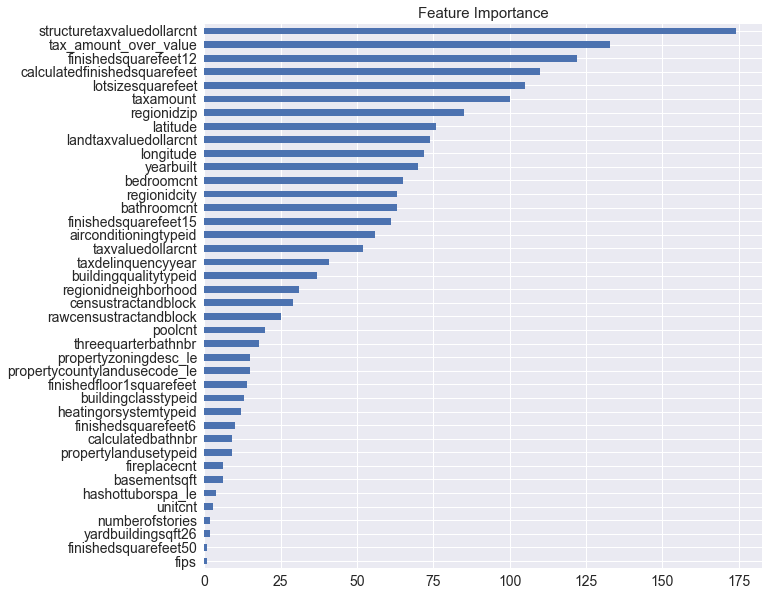

In [191]:
feature_importance = pd.Series(model.get_fscore()).sort_values(ascending=True)
feature_importance.plot.barh(x='feature_name', figsize = (10,10), fontsize=14)
plt.title('Feature Importance', fontsize = 15)